Purpose: check TPM values
        test official TPMs under /s/project/sra-download/files/dbGaP-11206/GTEx_Analysis_2016-01-15_v7_RSEMv1.2.22_transcript_tpm.txt.gz

In [2]:
# code autoreload
%load_ext autoreload
%autoreload 2
import os
import sys

import random
import math
import numpy.random as nr
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as scistats

import scanpy.api as sc
import anndata as ad
import xarray as xr
import dask.array as da

## init plotly
# from plotly.offline import iplot, init_notebook_mode
# init_notebook_mode(connected=True)
import plotly.io as pio
pio.renderers.default = 'iframe_connected'
import plotly.graph_objs as go

import sklearn
import keras as k



/opt/modules/i12g/anaconda/3-2018.12/envs/florian/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/opt/modules/i12g/anaconda/3-2018.12/envs/florian/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
Using TensorFlow backend.


In [3]:
CACHE_DIR="/s/project/rep/cache/"
RAW_DATA_DIR="/s/project/rep/raw/"
PROCESSED_DATA_DIR="/s/project/rep/processed/"

In [4]:
raw_data = ad.read_h5ad(os.path.join(PROCESSED_DATA_DIR, "gtex/OUTRIDER/l2fc.h5ad"))
raw_data = raw_data[:, ~ np.any(np.isnan(raw_data.X), axis=0)]

raw_data

View of AnnData object with n_obs × n_vars = 8166 × 8787 
    obs: 'individual', 'SMATSSCR', 'SMCENTER', 'SMPTHNTS', 'SMRIN', 'tissue', 'subtissue', 'SMUBRID', 'SMTSISCH', 'SMTSPAX', 'SMTSTPTREF', 'SMNABTCH', 'SMNABTCHT', 'SMNABTCHD', 'SMGEBTCH', 'SMGEBTCHD', 'SMGEBTCHT', 'SMAFRZE', 'SMGTC', 'SME2MPRT', 'SMCHMPRS', 'SMNTRART', 'SMNUMGPS', 'SMMAPRT', 'SMEXNCRT', 'SM550NRM', 'SMGNSDTC', 'SMUNMPRT', 'SM350NRM', 'SMRDLGTH', 'SMMNCPB', 'SME1MMRT', 'SMSFLGTH', 'SMESTLBS', 'SMMPPD', 'SMNTERRT', 'SMRRNANM', 'SMRDTTL', 'SMVQCFL', 'SMMNCV', 'SMTRSCPT', 'SMMPPDPR', 'SMCGLGTH', 'SMGAPPCT', 'SMUNPDRD', 'SMNTRNRT', 'SMMPUNRT', 'SMEXPEFF', 'SMMPPDUN', 'SME2MMRT', 'SME2ANTI', 'SMALTALG', 'SME2SNSE', 'SMMFLGTH', 'SME1ANTI', 'SMSPLTRD', 'SMBSMMRT', 'SME1SNSE', 'SME1PCTS', 'SMRRNART', 'SME1MPRT', 'SMNUM5CD', 'SMDPMPRT', 'SME2PCTS', 'ctsExists', 'SEX', 'AGE', 'DTHHRDY', 'sizeFactor', 'thetaCorrection'
    var: 'gene_symbol', 'basepairs', 'feature_mean'

In [5]:
np.unique(raw_data.obs.subtissue)

array(['Adipose_Subcutaneous', 'Adipose_Visceral_Omentum',
       'Adrenal_Gland', 'Artery_Aorta', 'Artery_Coronary',
       'Artery_Tibial', 'Brain_Anterior_cingulate_cortex_BA24',
       'Brain_Caudate_basal_ganglia', 'Brain_Cerebellar_Hemisphere',
       'Brain_Cerebellum', 'Brain_Cortex', 'Brain_Frontal_Cortex_BA9',
       'Brain_Hippocampus', 'Brain_Hypothalamus',
       'Brain_Nucleus_accumbens_basal_ganglia',
       'Brain_Putamen_basal_ganglia', 'Breast_Mammary_Tissue',
       'Cells_EBV_transformed_lymphocytes',
       'Cells_Transformed_fibroblasts', 'Colon_Sigmoid',
       'Colon_Transverse', 'Esophagus_Gastroesophageal_Junction',
       'Esophagus_Mucosa', 'Esophagus_Muscularis',
       'Heart_Atrial_Appendage', 'Heart_Left_Ventricle', 'Liver', 'Lung',
       'Muscle_Skeletal', 'Nerve_Tibial', 'Ovary', 'Pancreas',
       'Pituitary', 'Prostate', 'Skin_Not_Sun_Exposed_Suprapubic',
       'Skin_Sun_Exposed_Lower_leg', 'Small_Intestine_Terminal_Ileum',
       'Spleen', 'Stomac

In [6]:
blood = raw_data[raw_data.obs.subtissue == "Whole_Blood"]
lung = raw_data[raw_data.obs.subtissue == "Lung"]

# use intersection of both samples' individuals to get 1:1 mapping
individuals = list(set(blood.obs.individual) & set(lung.obs.individual))
random.shuffle(individuals)

blood = blood[blood.obs.reset_index().set_index("individual").loc[individuals]["index"]]
lung = lung[lung.obs.reset_index().set_index("individual").loc[individuals]["index"]]

assert blood.n_obs == lung.n_obs

# split data into test and train sets
testDelim = int(blood.n_obs * 0.8)

Xtrain = blood[:testDelim]
Ytrain = lung[:testDelim]

Xtest = blood[testDelim:]
Ytest = lung[testDelim:]

print("X_train:")
print(Xtrain)
print("Y_train:")
print(Ytrain)
print("X_test:")
print(Xtest)
print("Y_test:")
print(Ytest)



X_train:
View of AnnData object with n_obs × n_vars = 188 × 8787 
    obs: 'individual', 'SMATSSCR', 'SMCENTER', 'SMPTHNTS', 'SMRIN', 'tissue', 'subtissue', 'SMUBRID', 'SMTSISCH', 'SMTSPAX', 'SMTSTPTREF', 'SMNABTCH', 'SMNABTCHT', 'SMNABTCHD', 'SMGEBTCH', 'SMGEBTCHD', 'SMGEBTCHT', 'SMAFRZE', 'SMGTC', 'SME2MPRT', 'SMCHMPRS', 'SMNTRART', 'SMNUMGPS', 'SMMAPRT', 'SMEXNCRT', 'SM550NRM', 'SMGNSDTC', 'SMUNMPRT', 'SM350NRM', 'SMRDLGTH', 'SMMNCPB', 'SME1MMRT', 'SMSFLGTH', 'SMESTLBS', 'SMMPPD', 'SMNTERRT', 'SMRRNANM', 'SMRDTTL', 'SMVQCFL', 'SMMNCV', 'SMTRSCPT', 'SMMPPDPR', 'SMCGLGTH', 'SMGAPPCT', 'SMUNPDRD', 'SMNTRNRT', 'SMMPUNRT', 'SMEXPEFF', 'SMMPPDUN', 'SME2MMRT', 'SME2ANTI', 'SMALTALG', 'SME2SNSE', 'SMMFLGTH', 'SME1ANTI', 'SMSPLTRD', 'SMBSMMRT', 'SME1SNSE', 'SME1PCTS', 'SMRRNART', 'SME1MPRT', 'SMNUM5CD', 'SMDPMPRT', 'SME2PCTS', 'ctsExists', 'SEX', 'AGE', 'DTHHRDY', 'sizeFactor', 'thetaCorrection'
    var: 'gene_symbol', 'basepairs', 'feature_mean'
Y_train:
View of AnnData object with n_obs × 

In [111]:
n_features = Xtrain.n_vars
import tensorflow as tf
model = k.models.Sequential([
    k.layers.Dense(units = 100, input_shape=[n_features,], activation='relu'),
#     k.layers.Dropout(rate=0.3),
    k.layers.Dense(units = n_features, activation="linear"),
])

model.compile(loss = tf.losses.huber_loss, optimizer = k.optimizers.Adam(lr=0.01))


In [112]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 100)               878800    
_________________________________________________________________
dense_44 (Dense)             (None, 8787)              887487    
Total params: 1,766,287
Trainable params: 1,766,287
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(
    Xtrain.X, 
    Ytrain.X, 
    validation_split=0.2, 
    epochs = 100, 
    batch_size = 500,
    callbacks=[
        k.callbacks.EarlyStopping(
            patience=20,
            restore_best_weights=True
        ),
    ],
)

Train on 150 samples, validate on 38 samples
Epoch 1/100
150/150 [==============================] - 3s 19ms/step - loss: 0.0222 - val_loss: 0.0208
Epoch 2/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0212 - val_loss: 0.0207
Epoch 3/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0211 - val_loss: 0.0207
Epoch 4/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0211 - val_loss: 0.0207
Epoch 5/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0211 - val_loss: 0.0207
Epoch 6/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0210 - val_loss: 0.0208
Epoch 7/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0209 - val_loss: 0.0208
Epoch 8/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0209 - val_loss: 0.0208
Epoch 9/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0208 - val_loss: 0.0208
Epoch 10/100
150/150 [=======================

In [97]:
Ypred = model.predict(Xtest.X)

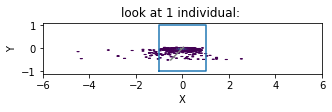

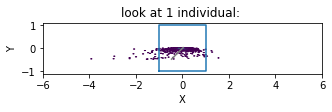

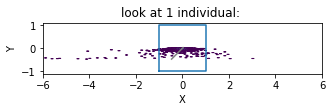

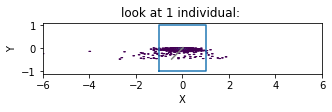

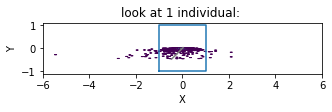

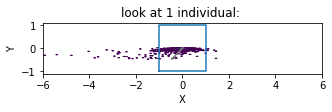

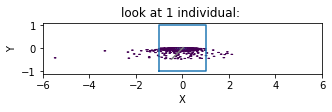

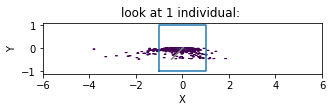

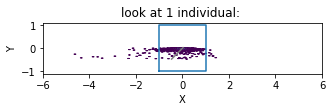

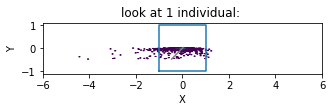

In [98]:


def plotIndiv(Xindiv, Yindiv, sizeFixed=True):
    ax=plt.gca()

    ax.set_aspect("equal")
    ax.figure.set_size_inches(5, 5)
    
    if sizeFixed:
        ax.set_xlim([-6,6])
    
    ax.plot((-1, -1, 1, 1, -1),(-1, 1, 1, -1, -1))
    ax.hexbin(Xindiv, Yindiv, mincnt=1)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title("look at 1 individual: ")
    
    diagVals=(
        max(
            min(Xindiv), min(Yindiv)
        ),
        min(
            max(Xindiv), max(Yindiv)
        )
    )
    
    ax.plot(diagVals, diagVals, color="grey")
    plt.show()
    
    
ids = np.asarray(Ytest.obs.reset_index().set_index("individual")[:10]["index"])

for id in range(10):
    y_obs = Ytest[id]
    y_hat = Ypred[id]
    plotIndiv(y_obs.X, y_hat)



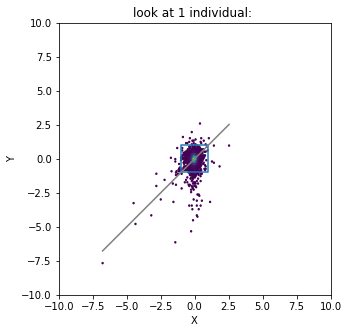

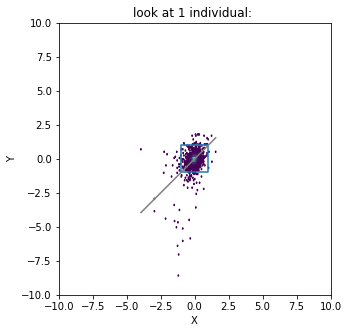

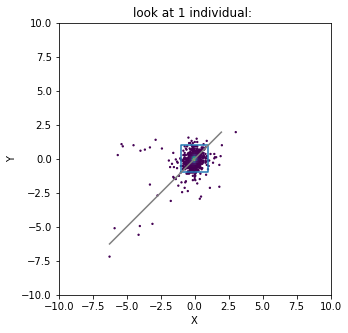

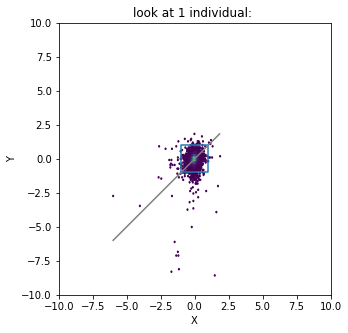

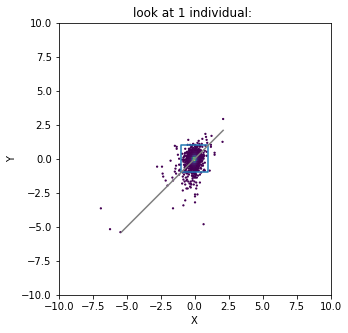

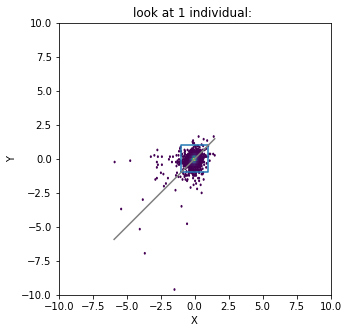

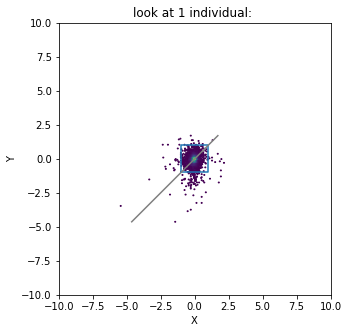

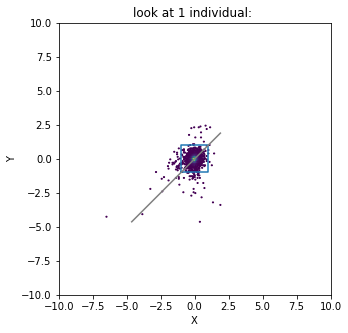

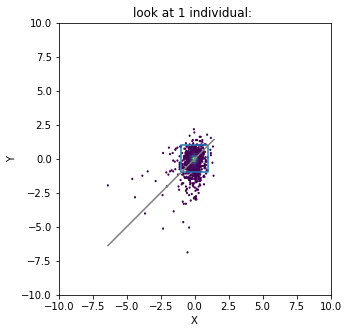

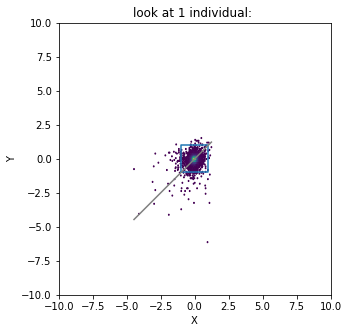

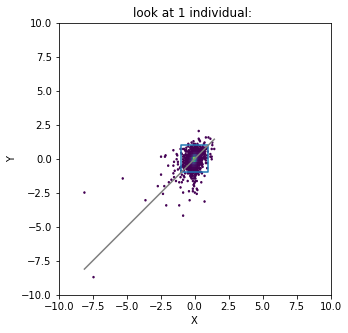

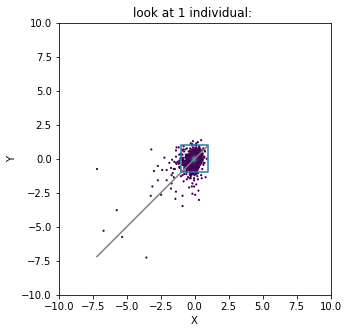

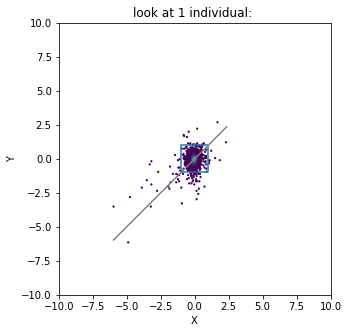

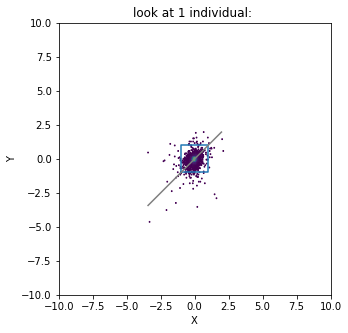

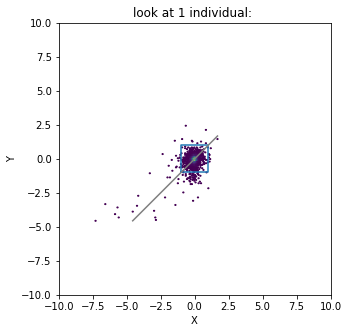

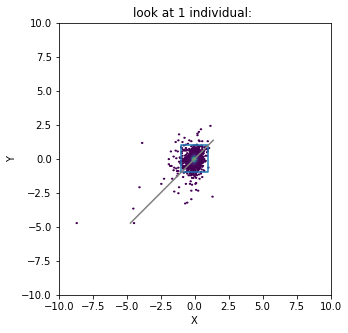

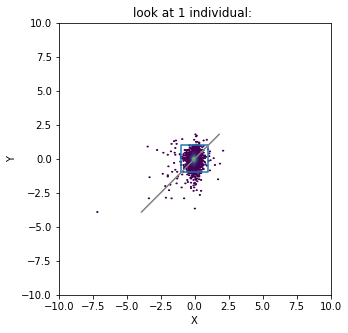

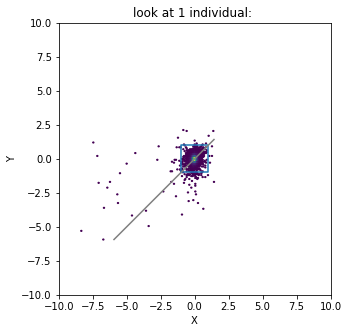

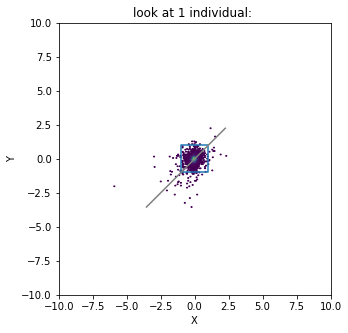

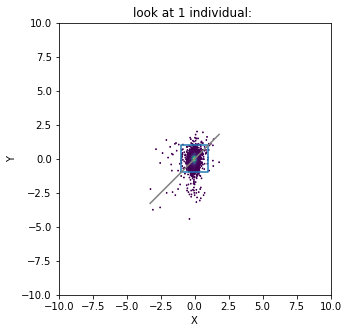

In [110]:


def plotIndiv(Xindiv, Yindiv, sizeFixed=True):
    ax=plt.gca()

    ax.set_aspect("equal")
    ax.figure.set_size_inches(5, 5)
    
    if sizeFixed:
        ax.set_xlim([-10,10])
        ax.set_ylim([-10,10])
    
    ax.plot((-1, -1, 1, 1, -1),(-1, 1, 1, -1, -1))
    ax.hexbin(Xindiv, Yindiv, mincnt=1)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title("look at 1 individual: ")
    
    diagVals=(
        max(
            min(Xindiv), min(Yindiv)
        ),
        min(
            max(Xindiv), max(Yindiv)
        )
    )
    
    ax.plot(diagVals, diagVals, color="grey")
    plt.show()
    
    
ids = np.asarray(Ytest.obs.reset_index().set_index("individual")[:10]["index"])

for id in range(20):
    y_obs = Ytest[id]
    y_hat = Xtest[id]
    plotIndiv(y_obs.X, y_hat.X)



In [21]:
ids = {"GTEX-X4LF", "GTEX-SIU7", "GTEX-XGQ4", "GTEX-TML8", "GTEX-OOBJ", "GTEX-12WSE", "GTEX-13O61", "GTEX-13OB8", "GTEX-S4Q7", "GTEX-11WQC", "GTEX-NL3G"}
ids & set(Ytest.obs.individual)

{'GTEX-NL3G'}

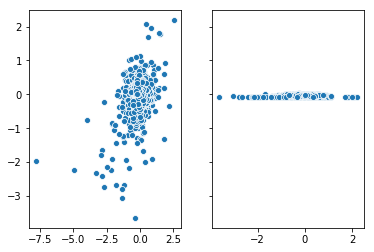

In [101]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.scatterplot(x=Xtest.X[0], y=Ytest.X[0], ax=ax1)
sns.scatterplot(x=Ytest.X[0], y=Ypred[0], ax=ax2)